   ---------------------------------------- 0.0/339.9 kB ? eta -:--:--
   --- ------------------------------------ 30.7/339.9 kB 1.4 MB/s eta 0:00:01
   ---------------------- ----------------- 194.6/339.9 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------  337.9/339.9 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 339.9/339.9 kB 2.6 MB/s eta 0:00:00
Initial conditions:
H2O: 55000.000 mM
CO2(aq): 33.000 mM
H+: 0.100 µM
OH-: 0.100 µM
H2CO3: 0.000 µM
HCO3-: 0.000 µM
CO3--: 0.000 µM

Final concentrations after initial equilibrium:
H2O: 55000.000 mM
H+: 33.000 mM
OH-: 0.100 µM
H2CO3: 0.100 µM
HCO3-: 0.000 µM
CO3--: 0.000 µM
CO2(aq): 0.000 µM

Concentrations after adding NaOH to reach pH 10:
H2O: 55000.000 mM
H+: 0.000 µM
OH-: 100.000 µM
H2CO3: 0.100 µM
HCO3-: 0.000 µM
CO3--: 0.000 µM
CO2(aq): 0.000 µM

Concentrations after adding 0.001 mol of CO2:
H2O: 54999.911 mM
H+: 0.000 µM
OH-: 100.000 µM
H2CO3: 89.362 µM
HCO3-: 0.000 µM
CO3--: 0.000 µM
CO2(aq): 91

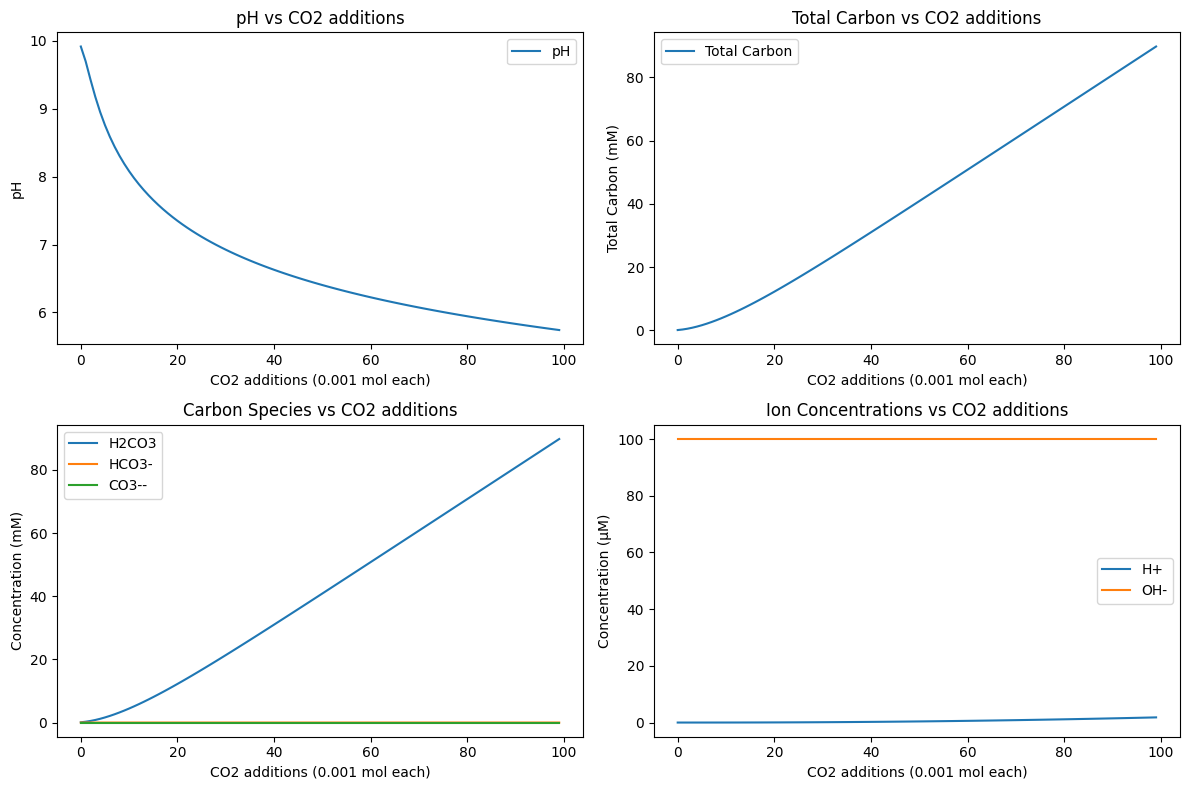

In [5]:
!pip install chempy
!pip install pytest

import math
import matplotlib.pyplot as plt
from chempy import Equilibrium, ReactionSystem
from chempy.kinetics.ode import get_odesys
from scipy.integrate import solve_ivp


# Constants
Kw = 1.0e-14  # Ion product of water at 25°C
K1 = 4.45e-7  # First dissociation constant of H2CO3 at 25°C
K2 = 4.69e-11  # Second dissociation constant of H2CO3 at 25°C
K_H = 1.7e-3  # Equilibrium constant for CO2(aq) + H2O ⇌ H2CO3
Henry_law_constant_CO2 = 3.3e-2  # Henry's law constant for CO2 in water at 25°C (mol/L*atm)
CO2_partial_pressure = 1.0  # Partial pressure of CO2 in 100% CO2 atmosphere (atm)

# Equilibria definitions
eq1 = Equilibrium({'H2O': 1}, {'H+': 1, 'OH-': 1}, Kw)
eq2 = Equilibrium({'CO2(aq)': 1, 'H2O': 1}, {'H2CO3': 1}, K_H)
eq3 = Equilibrium({'H2CO3': 1}, {'H+': 1, 'HCO3-': 1}, K1)
eq4 = Equilibrium({'HCO3-': 1}, {'H+': 1, 'CO3--': 1}, K2)

# Create ReactionSystem
rxn_system = ReactionSystem([eq1, eq2, eq3, eq4], 'H2O H+ OH- H2CO3 HCO3- CO3-- CO2(aq)')

# Initial conditions
initial_conditions = {
    'H2O': 55,  # Assume excess water
    'CO2(aq)': CO2_partial_pressure * Henry_law_constant_CO2,
    'H+': math.sqrt(Kw),
    'OH-': math.sqrt(Kw),
    'H2CO3': 0.0,
    'HCO3-': 0.0,
    'CO3--': 0.0,
}

# Function to convert and format concentration
def format_concentration(value):
    if value >= 1e-3:
        return f"{value * 1e3:.3f} mM"
    else:
        return f"{value * 1e6:.3f} µM"

# Print initial conditions
print("Initial conditions:")
for substance, conc in initial_conditions.items():
    print(f"{substance}: {format_concentration(conc)}")

# Solve equilibrium using scipy's solve_ivp
odesys, extra = get_odesys(rxn_system)
def odesys_wrapper(t, y):
    return odesys.f_cb(t, y)
y0 = list(initial_conditions.values())
result = solve_ivp(odesys_wrapper, [0, 1], y0, atol=1e-12, rtol=1e-12)
final_concs = result.y[:, -1]

# Convert and print final concentrations after initial equilibrium
substances = list(rxn_system.substances.keys())
concs_molar = {substances[i]: conc for i, conc in enumerate(final_concs)}
print("\nFinal concentrations after initial equilibrium:")
for substance, conc in concs_molar.items():
    print(f"{substance}: {format_concentration(conc)}")

# Raising the pH to 10 using NaOH
target_pH = 10
target_OH_concentration = Kw / (10 ** (-target_pH))
added_OH_concentration = target_OH_concentration - concs_molar['OH-']
concs_molar['OH-'] = target_OH_concentration
concs_molar['H+'] = Kw / target_OH_concentration

# Print concentrations after adding NaOH
print("\nConcentrations after adding NaOH to reach pH 10:")
for substance, conc in concs_molar.items():
    print(f"{substance}: {format_concentration(conc)}")

# Re-saturating with CO2 in increments of 0.001 mol
CO2_addition = 0.001
moles_CO2_added = 0.0

# Data lists for plotting
pH_values = []
total_carbon_values = []
H2CO3_values = []
HCO3_values = []
CO3_values = []
H_concentration_values = []
OH_concentration_values = []

while moles_CO2_added < 0.1:  # Limiting to 0.1 mol CO2 addition for demonstration
    moles_CO2_added += CO2_addition
    concs_molar['CO2(aq)'] += CO2_addition

    # Solve equilibrium after each addition of CO2
    y0 = list(concs_molar.values())
    result = solve_ivp(odesys_wrapper, [0, 1], y0, atol=1e-12, rtol=1e-12)
    final_concs = result.y[:, -1]
    concs_molar = {substances[i]: conc for i, conc in enumerate(final_concs)}

    # Print concentrations after each CO2 addition
    print(f"\nConcentrations after adding {moles_CO2_added:.3f} mol of CO2:")
    for substance, conc in concs_molar.items():
        print(f"{substance}: {format_concentration(conc)}")

    # Store data for plotting
    pH_values.append(-math.log10(concs_molar['H+']))
    total_carbon_values.append((concs_molar['H2CO3'] + concs_molar['HCO3-'] + concs_molar['CO3--']) * 1e3)  # Convert to mM
    H2CO3_values.append(concs_molar['H2CO3'] * 1e3)  # Convert to mM
    HCO3_values.append(concs_molar['HCO3-'] * 1e3)  # Convert to mM
    CO3_values.append(concs_molar['CO3--'] * 1e3)  # Convert to mM
    H_concentration_values.append(concs_molar['H+'] * 1e6)  # Convert to µM
    OH_concentration_values.append(concs_molar['OH-'] * 1e6)  # Convert to µM

# Plotting the data
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(len(pH_values)), pH_values, label="pH")
plt.xlabel("CO2 additions (0.001 mol each)")
plt.ylabel("pH")
plt.title("pH vs CO2 additions")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(len(total_carbon_values)), total_carbon_values, label="Total Carbon")
plt.xlabel("CO2 additions (0.001 mol each)")
plt.ylabel("Total Carbon (mM)")
plt.title("Total Carbon vs CO2 additions")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(range(len(H2CO3_values)), H2CO3_values, label="H2CO3")
plt.plot(range(len(HCO3_values)), HCO3_values, label="HCO3-")
plt.plot(range(len(CO3_values)), CO3_values, label="CO3--")
plt.xlabel("CO2 additions (0.001 mol each)")
plt.ylabel("Concentration (mM)")
plt.title("Carbon Species vs CO2 additions")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(range(len(H_concentration_values)), H_concentration_values, label="H+")
plt.plot(range(len(OH_concentration_values)), OH_concentration_values, label="OH-")
plt.xlabel("CO2 additions (0.001 mol each)")
plt.ylabel("Concentration (µM)")
plt.title("Ion Concentrations vs CO2 additions")
plt.legend()

plt.tight_layout()
plt.show()
